In [369]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
import scipy.stats as st
import seaborn as sns

In [239]:
events = pd.read_csv('../resources/trajectories-0400pm-0415pm_editted.csv')

In [240]:

#filter cars headed North only
North = events[events['Direction'] == 2].sort_values('Epoch_ms').reset_index(drop=True)
North.groupby('Vehicle_ID').first()

N1 = North[North['Org_Zone'].isin([113,114,115]) == False].groupby('Vehicle_ID').first()

#get last entry for end time
N2 = North[North['Org_Zone'].isin([113,114,115]) == False].groupby('Vehicle_ID').last()

# Filter out cars that exit on 10th street
Final = N1[N1['Dest_Zone'].isin([201,223,202])==False].groupby('Vehicle_ID').first()

#get first event recorded
origin = Final['Epoch_ms'].min()

def start(row):
    return((row-origin)/1000)

Final['start']=Final['Epoch_ms'].apply(start)
Final_last = N2[N2['Dest_Zone'].isin([201,223,202])==False]

Final['end'] = Final_last['Epoch_ms'].apply(start)

filtered_vehicles = Final.reset_index(drop=False)['Vehicle_ID'].unique()


In [241]:
filtered_events = events[events.Direction==2].sort_values('Epoch_ms').reset_index(drop=True)

filtered_events = filtered_events[filtered_events.Vehicle_ID.isin(filtered_vehicles)]

Text(0, 0.5, 'Number of vehicles entered')

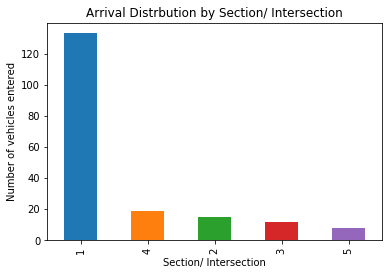

In [242]:
first_events = filtered_events.groupby('Vehicle_ID').first().reset_index()
(first_events.Intersection + first_events.Section).value_counts().plot.bar()
plt.title("Arrival Distrbution by Section/ Intersection")
plt.xlabel("Section/ Intersection")
plt.ylabel("Number of vehicles entered")

Text(0, 0.5, 'Number of vehicles left')

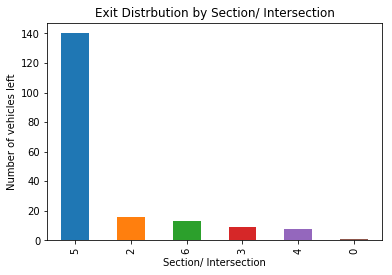

In [243]:
last_events = filtered_events.groupby('Vehicle_ID').last().reset_index()
(last_events.Intersection + last_events.Section).value_counts().plot.bar()
plt.title("Exit Distrbution by Section/ Intersection")
plt.xlabel("Section/ Intersection")
plt.ylabel("Number of vehicles left")

[]

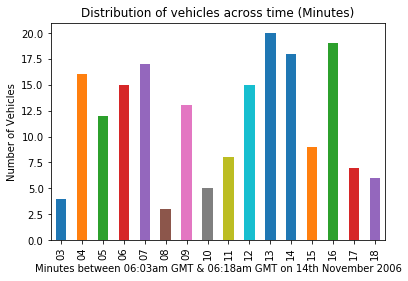

In [244]:
first_events['date_time'] = first_events.apply(lambda x: time.strftime('%m/%d/%Y %H:%M:%S',  time.localtime(x.Epoch_ms/1000)), axis=1)
first_events['date_time'] = pd.to_datetime(first_events.date_time)

min_dist = first_events.date_time.dt.strftime('%M').value_counts().sort_index()
ax = min_dist.plot.bar(style='k.')
ax.set_xticks(range(len(min_dist)))
ax.set_xticklabels(min_dist.index.tolist())
ax.set_title("Distribution of vehicles across time (Minutes)")
ax.set_xlabel("Minutes between 06:03am GMT & 06:18am GMT on 14th November 2006")
ax.set_ylabel("Number of Vehicles")
ax.plot()

[]

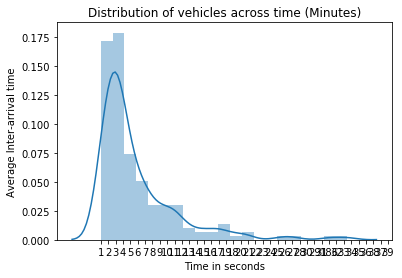

In [478]:
first_events['date_time'] = first_events.apply(lambda x: time.strftime('%m/%d/%Y %H:%M:%S',  time.localtime(x.Epoch_ms/1000)), axis=1)
first_events['date_time'] = pd.to_datetime(first_events.date_time)

min_dist = first_events.sort_values('Epoch_ms')['Epoch_ms'].diff().dropna()/1000#.dt.strftime('%M').value_counts().sort_index()
ax = sns.distplot(min_dist)
ax.set_xticks(range(len(min_dist)))
ax.set_xticklabels(min_dist.index.tolist())
ax.set_title("Distribution of vehicles across time (Minutes)")
ax.set_xlabel("Time in seconds")
ax.set_ylabel("Average Inter-arrival Time")
ax.plot()

### Test for Independence

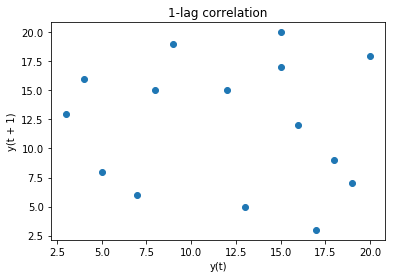

In [245]:

from pandas.plotting import lag_plot
ax = lag_plot(min_dist)
plt.title("1-lag correlation")
plt.show()

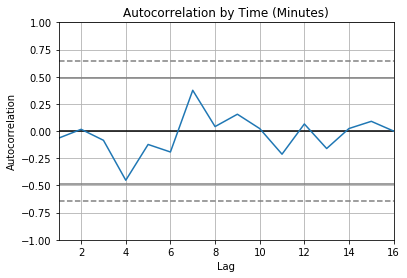

In [246]:
from pandas.plotting import autocorrelation_plot
min_dist = first_events.date_time.dt.minute.value_counts().sort_index()
autocorrelation_plot(min_dist)
plt.title("Autocorrelation by Time (Minutes)")
plt.show()

In [247]:
## Test Train Split
train = filtered_events.iloc[:int(filtered_events.shape[0]*0.8)]
test = filtered_events.iloc[int(filtered_events.shape[0]*0.8):]

1 6.305084745762711


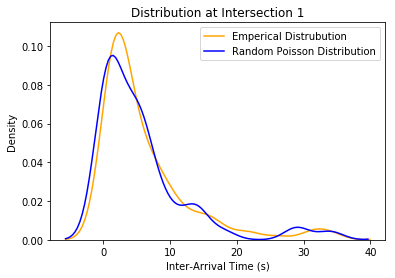

2 50.10833333333334


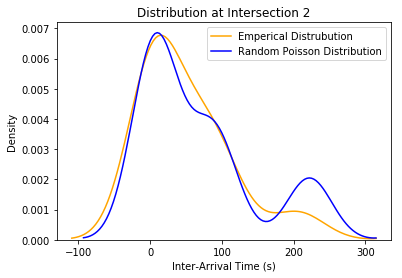

3 84.77499999999999


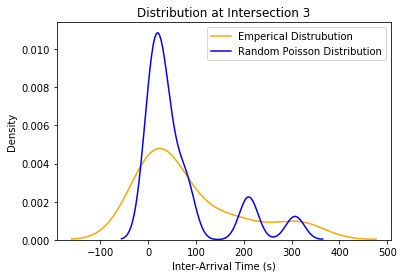

4 52.23846153846154


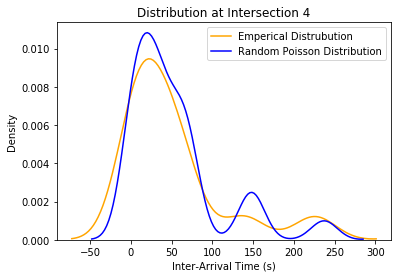

5 84.0


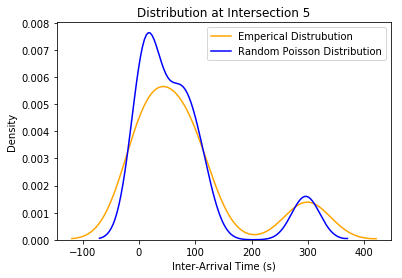

In [253]:
np.random.seed(10)
for intersection in range(1,6):
    first_train = train.groupby('Vehicle_ID').first().reset_index(drop=True)
    first_train = first_train[(first_train['Intersection'] == intersection) | (first_train['Section'] == intersection)][['Epoch_ms']].sort_values('Epoch_ms')
    first_train = first_train.sort_values('Epoch_ms')
    first_train = first_train.reset_index(drop=False)
    d = first_train['Epoch_ms'].diff().dropna().reset_index(drop=True)/1000.
   
    dist=[]
    r = np.random.poisson(d.values, d.shape[0])
    print(intersection, d.mean())
    
    for i in range(100):
        dist.append(np.random.choice(r))
    hist, bin_edges = np.histogram(d, bins=int(d.max()-d.min()), density=True)
    '''
    np.cumsum(hist)
    # plt.plot(bin_edges[1:], np.cumsum(hist))
    # plt.show()
    v = []
    F = np.cumsum(hist)
    for i in range(100):
        u = np.random.random()
        i = np.searchsorted(F, u, side="right")
        v.append(bin_edges[i])
    '''

   
    ax = plt.gca()
    sns.kdeplot(d, color="orange", label="Emperical Distrubution",ax=ax)
    sns.kdeplot(dist, color="blue", label="Random Poisson Distribution",ax=ax)
   #sns.kdeplot(v, color="green", label="Empirical Distribution",ax=ax)
    plt.xlabel("Inter-Arrival Time (s)")
    plt.ylabel("Density")
    tlt = "Distribution at Intersection "+str(intersection)
    plt.title(tlt)
    #plt.xlim([0, d.max()])
    plt.legend()
    plt.show()

In [254]:
def findDist(df, section, intersection):
    return df[(df.Section == section) | (df.Intersection ==intersection)][['Epoch_ms']].sort_values('Epoch_ms').diff().dropna().mean()/1000
    

In [317]:
def compute(df):
    df_first = df.groupby('Vehicle_ID').first().reset_index()
    print("Lamda values for Poisson Distribution")
    print("Section 1: ", findDist(df_first, 1, 1))
    print("Section 2: ", findDist(df_first, 2, 2))
    print("Section 3: ", findDist(df_first, 3, 3))
    print("Section 4: ", findDist(df_first, 4, 4))
    print("Section 5: ", findDist(df_first, 5, 5))
    print("\n")
    
    f = df.sort_values('Epoch_ms').groupby('Vehicle_ID').first()
    l = df.sort_values('Epoch_ms').groupby('Vehicle_ID').last()
    f = f[(f.Intersection == 1) | (f.Section == 1)]
    l = l[(l.Intersection == 5) | (l.Section == 6)]
    travel_time = (l['Epoch_ms'] - f['Epoch_ms']).dropna()
    print("Mean Travel Time: " , travel_time.mean()/1000)
    print("Total Duration under study: ", (l.Epoch_ms.max() - f.Epoch_ms.min())/1000 )
    print("Max Travel Time", (travel_time.max()/1000 ))
    print("Min Travel Time", travel_time.min()/1000 )
    print("Total Number of cars: ", len(df_first.Vehicle_ID.unique()) )
    print("Number of cars that travelled across the corridor: ", len(travel_time) )
    sns.distplot(travel_time/1000, kde=False, norm_hist=False)
    plt.xlabel('Time (Seconds)')
    plt.ylabel('# Vehicles')
    return travel_time


Lamda values for Poisson Distribution
Section 1:  Epoch_ms    6.305085
dtype: float64
Section 2:  Epoch_ms    50.108333
dtype: float64
Section 3:  Epoch_ms    84.775
dtype: float64
Section 4:  Epoch_ms    52.238462
dtype: float64
Section 5:  Epoch_ms    84.0
dtype: float64


Mean Travel Time:  132.9645569620253
Total Duration under study:  758.4
Max Travel Time 237.6
Min Travel Time 67.9
Total Number of cars:  163
Number of cars that travelled across the corridor:  79


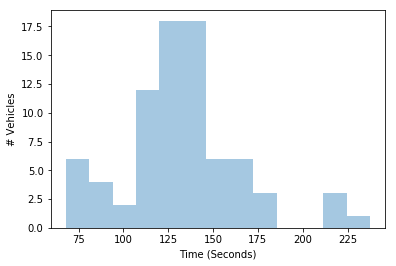

In [318]:
_= compute(train)

Lamda values for Poisson Distribution
Section 1:  Epoch_ms    10.315385
dtype: float64
Section 2:  Epoch_ms    25.54
dtype: float64
Section 3:  Epoch_ms    11.622222
dtype: float64
Section 4:  Epoch_ms    8.5625
dtype: float64
Section 5:  Epoch_ms    0.007143
dtype: float64


Mean Travel Time:  125.61538461538461
Total Duration under study:  237.3
Max Travel Time 169.0
Min Travel Time 81.6
Total Number of cars:  54
Number of cars that travelled across the corridor:  13


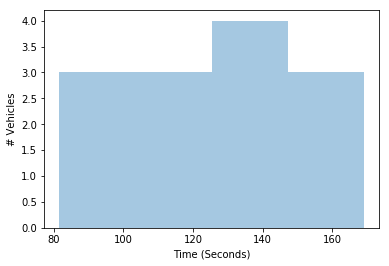

In [319]:
_ = compute(test)

### Output Analysis (Event-Oriented Model)

## NGSIM Validation

Text(0, 0.5, 'Travel Time')

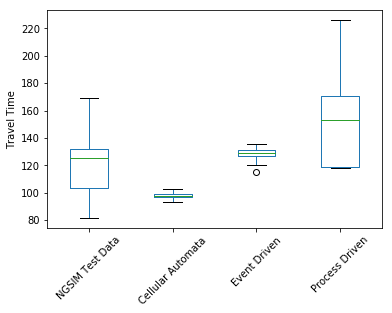

In [503]:
process = pd.Series([175.47,225.78,168.73,118.83,170.19,163.86,141.84,177.92,153.10,182.05,118.83,163.86,118.33,153.73,168.73,141.84,118.33,159.65,118.33,172.04,171.26,163.86,118.83,118.33,171.17,118.33,118.83,153.10,118.33,177.92,118.83,118.33,118.83,153.10,147.65,118.33,118.33,118.83,141.84,188.09,118.33,141.84,155.19,175.47,118.33,141.84,177.07,170.19,189.31,146.10,182.03,178.28,191.48,166.71,159.65,172.61,118.83,118.83,180.12,171.26,163.86,141.84,153.10,172.04,118.33,175.85,160.48,141.84,141.84,170.19,152.61,172.61,118.83,166.71,170.19,118.83,118.83,118.83,159.65,144.60,141.84,159.65,118.33,149.98])
cellular = pd.Series([98.84057971,98.46428571,100.03174603,98.63492063,95.08108108,98.31034483,99.18032787,101.30909091,100.63492063,99.17241379,100.70175439,98.51612903,94.13559322,97.1147541,95.07142857,95.6,93.75438596,97.96825397,97.69230769,97.55932203,96.54545455,96.20338983,95.87755102,95.91044776,93.58490566,96.23529412,97.49253731,99.8974359,97.69491525,97.85294118,99.46153846,98.60714286,94.03636364,97.48148148,98.,99.93103448,98.36923077,98.28070175,96.49275362,102.55737705,94.43137255,97.83870968,99.44827586,99.09090909,96.84210526,99.31034483,100.44067797,95.66037736,97.41538462,97.1641791,101.37704918,95.46428571,97.1884058,97.47058824,96.19354839,97.01587302,96.98360656,99.59375,96.03773585,98.10169492,97.16666667,98.78787879,101.50877193,97.69230769,99.38709677,97.96825397,99.06060606,99.9245283,96.1509434,100.34615385,99.85454545,97.81818182,97.66153846,100.89855072,100.66666667,100.12121212,99.78947368,98.1,96.68656716,98.06451613,98.29032258,97.71428571,96.93548387,98.03225806,100.44827586,98.59649123,98.2295082,98.6779661,97.83606557,97.49253731,100.66666667,95.71428571,100.27118644,98.31746032,96.17241379,97.74074074,97.33333333,96.94915254,101.06122449,98.98113208,98.24615385])
f = test.sort_values('Epoch_ms').groupby('Vehicle_ID').first()
l = test.sort_values('Epoch_ms').groupby('Vehicle_ID').last()
f = f[(f.Intersection == 1) | (f.Section == 1)]
l = l[(l.Intersection == 5) | (l.Section == 6)]
travel_time = (l['Epoch_ms'] - f['Epoch_ms']).dropna()/1000

simTravelTime = pd.read_csv('output/NGSIM.txt')
event= simTravelTime.MeanTravelTime

df = pd.concat([travel_time, cellular, event, process], axis=1)
df.columns= ["NGSIM Test Data","Cellular Automata","Event Driven", "Process Driven"]
df.boxplot()
plt.xticks(rotation=45)

plt.grid(None)
plt.ylabel("Travel Time")

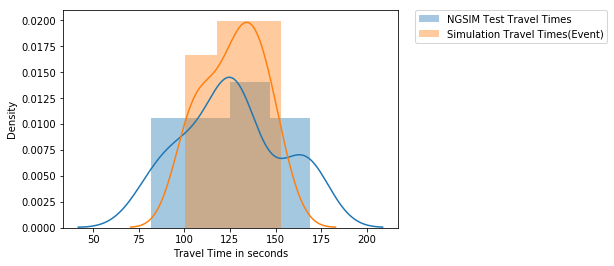

In [472]:
## Event Oriented Model
simTravelTime = pd.read_csv('output/TravelTimePerCar.txt', names=['id', 'time'])
sns.distplot(travel_time, label="NGSIM Test Travel Times" )
sns.distplot(simTravelTime.time, label="Simulation Travel Times(Event)" )
plt.xlabel("Travel Time in seconds")
#plt.legend()
plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

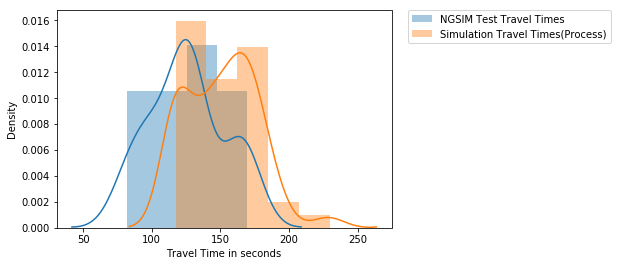

In [502]:
## Process Oriented Model
simTravelTime = pd.Series([117.3333333,117.3333333,118.3333333,169.1936508,135.7166667,167.4833333,117.8333333,166.3575758,194.7666667,145.9466667,184.7174603,117.3333333,184.7174603,186.0393939,167.4833333,142.3555556,134.7166667,180.0058824,229.8212121,118.3333333,190.4641026,172.4177778,172.9192982,166.3575758,118.3333333,145.9466667,186.0393939,160.5416667,117.3333333,179.6045977,117.8333333,173.8844444,152.6,152.6,118.3333333,163.0222222,163.0222222,145.9466667,145.9466667,145.9466667,157.2095238,227.2046512,118.3333333,118.3333333,157.2095238,172.4844444,174.3148148,135.7166667,160.5416667,135.7166667,171.3190476,143.1466667,117.3333333,176.9133333,145.9466667,137.5466667,160.5416667,146.6,168.3589744,145.0222222,130.7166667,164.9066667,160.5416667,176.1916667,152.6,157.2095238,166.3575758,118.3333333,117.8333333,135.7166667,145.9466667,181.4765432,172.4416667,152.6,117.3333333,117.8333333,135.7166667,117.8333333,118,118.3333333,138.1,117.3333333,157.2095238,173.8844444,167.4833333,117.3333333,118.3333333,164.9066667,168.9333333])
sns.distplot(travel_time, label="NGSIM Test Travel Times" )
sns.distplot(simTravelTime, label="Simulation Travel Times(Process)" )
plt.xlabel("Travel Time in seconds")
#plt.legend()
plt.ylabel("Density")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Lamda Variations (Traffic Variations)

In [390]:
res = pd.read_csv('output/LambdaVariations.txt');

Text(0.5, 1.0, 'Variation of Mean Travel Time with Inter-arrival Time (Poisson Lambda)')

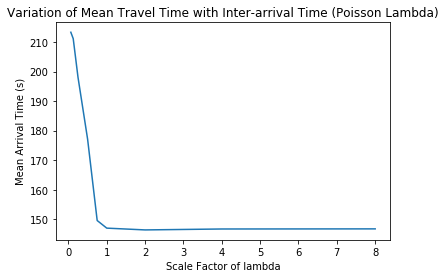

In [391]:
## Run Time = 500sec.
ax = sns.lineplot(x='factor', y="Mean", data=res)

plt.xlabel("Scale Factor of lambda")
plt.ylabel("Mean Arrival Time (s)")
plt.title("Variation of Mean Travel Time with Inter-arrival Time (Poisson Lambda)")

Text(0.5, 1.0, 'Variation of mean travel time with inter-arrival time')

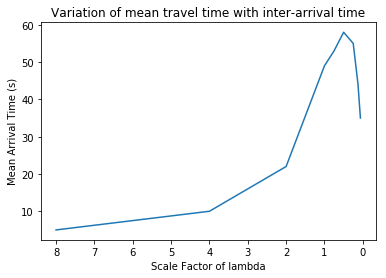

In [387]:
ax = sns.lineplot(x='factor', y="CarsCrossed", data=res)
ax.invert_xaxis()
plt.xlabel("Scale Factor of lambda")
plt.ylabel("Mean Arrival Time (s)")
plt.title("Variation of mean travel time with inter-arrival time")

## Vehicle Length Variations

Text(0.5, 1.0, 'Variation of mean travel time with Vehicle Length')

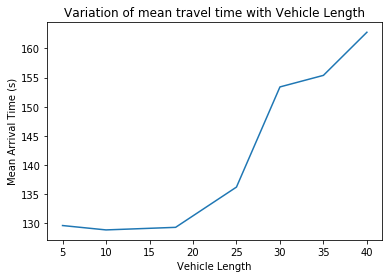

In [500]:
res = pd.read_csv('output/VehicleLengthVariations.txt');
## Run Time = 350sec.
ax = sns.lineplot(x='Length', y="Mean", data=res)
plt.xlabel("Vehicle Length")
plt.ylabel("Mean Arrival Time (s)")
plt.title("Variation of mean travel time with Vehicle Length")

## Traffic Light Variations

In [491]:
lightSim = pd.DataFrame([147.00372, 116.57, 210.7502])
lightSim.index = ["Real Signal Data ", "2x Green", "2x Red"]

Text(0.5, 1.0, 'Variation of Mean Travel Time with Traffic Signal Duration')

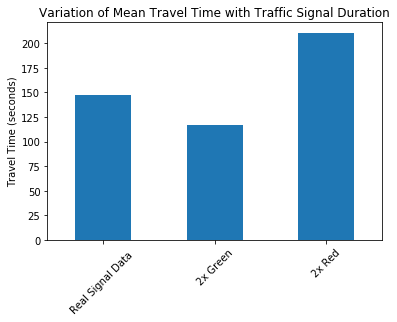

In [499]:
ax=lightSim.plot.bar()
ax.get_legend().remove()
plt.xticks(rotation=45)
plt.ylabel("Travel Time (seconds)")
plt.title("Variation of Mean Travel Time with Traffic Signal Duration")

## Confidence Interval

In [412]:
output = pd.read_csv('output/NGSIM.txt');

Text(0, 0.5, 'Density')

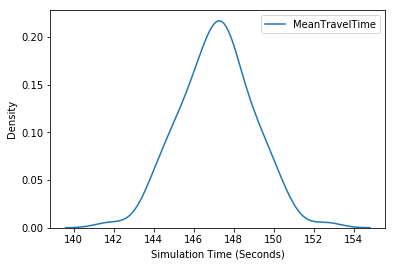

In [414]:
sns.kdeplot(output.MeanTravelTime)
plt.xlabel('Simulation Time (Seconds)')
plt.ylabel('Density')


In [415]:
output.head()


,iterationNumber,MeanTravelTime,WarmUpTime,CarsInSimulationCount,CarsAcrossCorridorCount
0,0,145.734,100.222222,113,43
1,1,146.856,100.222222,120,41
2,2,146.831,100.222222,118,46
3,3,146.127,100.222222,113,42
4,4,145.556,100.222222,114,48


0.30216093726521986


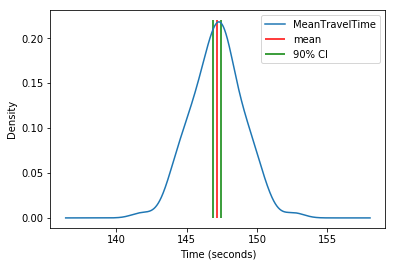

In [484]:
meanTravelTime = output.MeanTravelTime;
ax = meanTravelTime.plot.kde()

(m, neg_conf, pos_conf) = mean_confidence_interval(output.MeanTravelTime, 0.90)

#stderr = st.sem(meanTravelTime)
ax.vlines( x=m, ymin=0, ymax=0.22, color='red', label='mean' )
stderr = 0.1
ax.vlines( neg_conf, ymin=0, ymax=0.22, color='green', label='90% CI' )
ax.vlines( pos_conf, ymin=0, ymax=0.22, color='green' )
#ax.set_ylim([-1,12])
plt.xlabel("Time (seconds)")
ax.legend()
plt.show()

In [417]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    print(h)
    return m, m-h, m+h

In [482]:
mean_confidence_interval(output.MeanTravelTime, 0.90)

0.30216093726521986


(147.13702, 146.83485906273478, 147.43918093726523)